# Recipe Recommendation MVP with RAG

This notebook creates an intelligent recipe recommendation system that:
- **Uses RAG (Retrieval-Augmented Generation)** to search recipe PDFs first
- **Falls back to Gemini AI** if recipe not found in PDFs
- Collects user preferences (region, taste, time, allergies, dislikes)
- Takes available ingredients from user
- Recommends personalized recipes using AI + Recipe Books
- Provides step-by-step cooking instructions (one at a time)
- Suggests ingredient alternatives when needed
- Generates image descriptions for cooking steps

## 📚 How RAG Works Here:
1. **Load Recipe PDFs** → Extract text from recipe books
2. **Create Embeddings** → Convert recipes to vector representations
3. **Store in Vector DB** → Index for fast semantic search
4. **User Query** → Search for relevant recipes in PDFs
5. **Found?** → Use PDF recipe + AI enhancement
6. **Not Found?** → Use Gemini AI to generate recipe

## 🚀 Quick Start:
1. Create a `Pdfs` folder in this directory
2. Add your recipe PDF files (cookbooks, recipe collections, etc.)
3. Run all cells from top to bottom
4. Follow the interactive prompts!

## Step 1: Install Required Libraries

In [27]:
!pip install --upgrade langchain langchain-google-genai langchain-core langchain-community python-dotenv pillow requests pypdf faiss-cpu 

  Using cached langchain_core-1.0.0-py3-none-any.whl.metadata (3.4 kB)
Using cached langchain_core-1.0.0-py3-none-any.whl (467 kB)
   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
   ------------------------------------- -- 2.4/2.5 MB 13.4 MB/s eta 0:00:01
   ---------------------------------------- 2.5/2.5 MB 10.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ---------------------------------------- 1.0/1.0 MB 8.5 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.79
    Uninstalling langchain-core-0.3.79:
      Successfully uninstalled langchain-core-0.3.79
  Attempting uninstall: langchain-text-splitters
    Found existing installation: langchain-text-splitters 0.3.11
    Uninstalling langchain-text-splitters-0.3.11:
      Successfully uninstalled langchain-text-splitters-0.3.11
  Attempting uninstall: langchain-google-genai
    Found existing installation: langcha


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Step 1a: Google Colab Setup (Optional - Skip if using local Jupyter)

**If you're using Google Colab**, run the cell below to mount your Google Drive:
- This allows you to access PDFs stored in your Google Drive
- After running, you'll be prompted to authorize access
- Your Drive will be available at `/content/drive/MyDrive/`

## Step 2b: Setup Image Generation with Google Imagen (Optional - for Real Images!)

**Currently**: The system generates text descriptions of cooking steps.  
**With this step**: Generate actual AI images using Google's Imagen!

### 🎨 Google Imagen Setup:

**What you need:**
1. **Google Cloud Project ID** - Your GCP project
2. **Vertex AI API enabled** - ✅ You already did this!
3. **Google API Key** - Same one used for Gemini (already in your .env)

**Benefits of Imagen:**
- 🌟 Superior food photography quality
- 🔗 Native Google integration
- 🎯 Better understanding of cooking contexts
- 📸 More realistic food images

**To enable:**
- Add `GOOGLE_PROJECT_ID` to your `.env` file
- Or enter it when prompted below
- Run the cell below!

In [1]:
# Optional: Setup Image Generation with Stable Diffusion (Local GPU)
# This enables REAL image generation using your RTX 3050 GPU!

import warnings
import os
from dotenv import load_dotenv

warnings.filterwarnings('ignore')

# Setup image generation with local Stable Diffusion
IMAGE_GENERATION_ENABLED = False
stable_diffusion_pipe = None

try:
    import torch
    from diffusers import StableDiffusionPipeline
    import gc
    
    # Check if CUDA is available
    if torch.cuda.is_available():
        print("🎮 GPU detected! Setting up Stable Diffusion...")
        print(f"   GPU: {torch.cuda.get_device_name(0)}")
        print(f"   VRAM: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
        
        device = "cuda"
        dtype = torch.float16
        
        # Load the pre-trained Stable Diffusion model
        print("\n📥 Loading Stable Diffusion model...")
        print("   (This will download ~4GB on first run)")
        model_id = "runwayml/stable-diffusion-v1-5"
        
        stable_diffusion_pipe = StableDiffusionPipeline.from_pretrained(
            model_id, 
            torch_dtype=dtype,
            safety_checker=None,  # Disabled to save VRAM
            requires_safety_checker=False
        )
        
        # Move to device with memory optimizations for 4GB VRAM
        stable_diffusion_pipe = stable_diffusion_pipe.to(device)
        
        # Enable memory optimizations for low VRAM
        print("🔧 Enabling memory optimizations for 4GB VRAM...")
        stable_diffusion_pipe.enable_attention_slicing()  # Reduces VRAM usage
        stable_diffusion_pipe.enable_vae_slicing()        # Further reduces VRAM usage
        
        IMAGE_GENERATION_ENABLED = True
        
        print("✅ Image generation ENABLED with GPU acceleration!")
        print("   Model: Stable Diffusion 1.5 (Local)")
        print("   You'll see REAL images when you type 'image' during cooking!")
        print("   Generation time: ~10-30 seconds per image")
        
    else:
        print("⚠️  No CUDA detected!")
        print("   Image generation will use text descriptions only")
        print("\n💡 To enable GPU acceleration:")
        print("   1. Make sure you have NVIDIA drivers installed")
        print("   2. Run the Image_gen.ipynb notebook cells 1-3 to install PyTorch with CUDA")
        print("   3. Restart this kernel and re-run this cell")
        
except ImportError as e:
    print(f"⚠️  Required libraries not installed: {e}")
    print("   Run the Image_gen.ipynb notebook to install PyTorch and Stable Diffusion")
    print("   Image generation will use text descriptions only")
except Exception as e:
    print(f"⚠️  Could not enable image generation: {e}")
    print("   Will use text descriptions instead")

🎮 GPU detected! Setting up Stable Diffusion...
   GPU: NVIDIA GeForce RTX 3050 Laptop GPU
   VRAM: 4.00 GB

📥 Loading Stable Diffusion model...
   (This will download ~4GB on first run)


Loading pipeline components...: 100%|██████████| 6/6 [00:04<00:00,  1.25it/s]



🔧 Enabling memory optimizations for 4GB VRAM...
✅ Image generation ENABLED with GPU acceleration!
   Model: Stable Diffusion 1.5 (Local)
   You'll see REAL images when you type 'image' during cooking!
   Generation time: ~10-30 seconds per image


In [21]:
# ONLY RUN THIS CELL IF YOU'RE USING GOOGLE COLAB
# This mounts your Google Drive so you can access PDFs stored there

try:
    from google.colab import drive
    drive.mount('/content/drive')
    print("✅ Google Drive mounted successfully!")
    print("   Your Drive is accessible at: /content/drive/MyDrive/")
    print("   Example: If your PDFs are in 'Cook_pdf' folder:")
    print("   Path would be: /content/drive/MyDrive/Cook_pdf")
except ImportError:
    print("ℹ️  Not running in Google Colab - skipping Drive mount")
    print("   (This is fine if you're using local Jupyter)")

ℹ️  Not running in Google Colab - skipping Drive mount
   (This is fine if you're using local Jupyter)


## Step 2: Import Libraries and Setup

In [2]:
import getpass
import os
from langchain.chat_models import init_chat_model
from langchain_google_genai import GoogleGenerativeAIEmbeddings, ChatGoogleGenerativeAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import PyPDFDirectoryLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from PIL import Image
import requests
from io import BytesIO
import base64
from IPython.display import display

# Get API key from .env file or prompt user
from dotenv import load_dotenv
load_dotenv()

# For Google Colab: Get API key from Colab secrets
try:
    from google.colab import userdata
    GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
    print("🔑 Using API key from Google Colab secrets")
except:
    # For local Jupyter: Use environment variable or prompt
    GOOGLE_API_KEY = os.environ.get("GOOGLE_API_KEY")
    if not GOOGLE_API_KEY:
        GOOGLE_API_KEY = getpass.getpass("Enter API key for Google Gemini: ")
    print("🔑 Using API key from environment/input")

# Initialize Gemini model for text generation - IMPORTANT: Pass API key explicitly!
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    google_api_key=GOOGLE_API_KEY
)

# Initialize Gemini model with vision capability for image generation
vision_llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    google_api_key=GOOGLE_API_KEY
)

# Initialize embeddings for RAG - IMPORTANT: Pass the API key explicitly!
embeddings = GoogleGenerativeAIEmbeddings(
    model="models/gemini-embedding-001",
    google_api_key=GOOGLE_API_KEY
)

print("✅ Setup complete!")
print(f"✅ Model: gemini-2.5-flash-exp")
print(f"✅ Vision Model: gemini-2.5-flash-exp")
print(f"✅ Embeddings: gemini-embedding-001")
print(f"✅ Vector Store: FAISS (persistent storage)")
print(f"✅ Image generation ready!")
print(f"✅ All models authenticated with your API key!")

🔑 Using API key from environment/input
✅ Setup complete!
✅ Model: gemini-2.5-flash-exp
✅ Vision Model: gemini-2.5-flash-exp
✅ Embeddings: gemini-embedding-001
✅ Vector Store: FAISS (persistent storage)
✅ Image generation ready!
✅ All models authenticated with your API key!


## Step 3: Load Recipe PDFs and Create Vector Store (RAG with FAISS)

### 🚀 What is FAISS?
**FAISS** (Facebook AI Similarity Search) is a library for efficient similarity search. We use it to:
- **Save embeddings to disk** → No need to re-process PDFs every time!
- **Fast retrieval** → Optimized for searching millions of vectors
- **Persistent storage** → Your index is saved and can be reused

### 💾 How it works:
1. **First run**: Processes PDFs → Creates embeddings → Saves to `recipe_faiss_index` folder
2. **Subsequent runs**: Loads from `recipe_faiss_index` → **Instant startup!**
3. **To rebuild**: Delete the `recipe_faiss_index` folder and re-run

### 📁 PDF Setup Options:

**Option 1: Local Jupyter Notebook**
- Create a `Pdfs` folder in the same directory as this notebook
- Add your recipe PDF files there
- Run the cell below as-is (default path)
- FAISS index will be saved in `recipe_faiss_index` folder

**Option 2: Google Colab with Google Drive**
- Run the "Mount Google Drive" cell above (Step 1a)
- Upload your PDFs to a folder in Google Drive (e.g., `Cook_pdf`)
- Modify the cell below to use your Google Drive path:
  ```python
  recipe_vector_store = load_recipe_pdfs(
      "/content/drive/MyDrive/Cook_pdf",
      "/content/drive/MyDrive/recipe_faiss_index"  # Save index to Drive too!
  )
  ```

### 🔍 Supported PDF Types:
- Recipe books, cookbooks
- Cooking magazines
- Recipe collections
- Any PDF with cooking instructions

### 📂 Files Created:
After running, you'll see a `recipe_faiss_index` folder with:
- `index.faiss` - The FAISS vector index
- `index.pkl` - Metadata and document mapping

In [3]:
def load_recipe_pdfs(pdf_directory="Pdfs", faiss_index_path="recipe_faiss_index"):
    """Load and process recipe PDFs into FAISS vector store with persistent storage
    
    Args:
        pdf_directory: Path to PDF folder
                      Local Jupyter: "Pdfs" (default)
                      Google Colab: "/content/drive/MyDrive/Cook_pdf" (or your folder path)
        faiss_index_path: Path to save/load FAISS index (default: "recipe_faiss_index")
    """
    
    # Check if FAISS index already exists (skip processing if it does)
    if os.path.exists(faiss_index_path):
        print(f"📦 Found existing FAISS index at '{faiss_index_path}'")
        print("   Loading pre-computed embeddings (this is fast!)...")
        try:
            vector_store = FAISS.load_local(
                faiss_index_path, 
                embeddings,
                allow_dangerous_deserialization=True  # Required for FAISS
            )
            print("✅ FAISS index loaded successfully!")
            print("   💡 To rebuild index, delete the folder and re-run this cell")
            return vector_store
        except Exception as e:
            print(f"⚠️  Error loading FAISS index: {e}")
            print("   Will rebuild from PDFs...")
    
    # If no existing index, process PDFs
    print(f"📚 Loading recipe PDFs from '{pdf_directory}' folder...")
    
    # Check if directory exists and has PDFs
    if not os.path.exists(pdf_directory):
        print(f"⚠️  Warning: '{pdf_directory}' folder not found.")
        
        # Try to detect if we're in Google Colab
        try:
            from google.colab import drive
            print("\n💡 You're in Google Colab! To use PDFs from Google Drive:")
            print("   1. Make sure you ran the 'Mount Google Drive' cell above")
            print("   2. Upload PDFs to a folder in your Google Drive (e.g., 'Cook_pdf')")
            print("   3. Re-run this cell with the correct path, for example:")
            print("      recipe_vector_store = load_recipe_pdfs('/content/drive/MyDrive/Cook_pdf')")
        except ImportError:
            print(f"   Creating '{pdf_directory}' folder locally...")
            os.makedirs(pdf_directory)
            print(f"   Please add your recipe PDF files to the '{pdf_directory}' folder")
        
        return None
    
    # Check for PDF files
    pdf_files = [f for f in os.listdir(pdf_directory) if f.lower().endswith('.pdf')]
    
    if not pdf_files:
        print(f"⚠️  Warning: No PDF files found in '{pdf_directory}' folder")
        print("   The system will use only Gemini AI for recipe recommendations")
        return None
    
    print(f"   Found {len(pdf_files)} PDF file(s): {', '.join(pdf_files)}")
    
    try:
        # Load PDFs
        print("   Loading PDFs...")
        loader = PyPDFDirectoryLoader(pdf_directory)
        documents = loader.load()
        
        if not documents:
            print("   No content could be extracted from PDFs")
            return None
        
        print(f"   ✅ Loaded {len(documents)} page(s) from PDFs")
        
        # Split documents into chunks
        print("   Splitting documents into chunks...")
        text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=1000,
            chunk_overlap=200,
            separators=["\n\n", "\n", " ", ""]
        )
        splits = text_splitter.split_documents(documents)
        print(f"   ✅ Split into {len(splits)} chunks")
        
        # Create FAISS vector store with embeddings
        print("   Creating FAISS vector store with embeddings...")
        print("   (This may take a few minutes for large PDFs...)")
        vector_store = FAISS.from_documents(splits, embeddings)
        
        # Save FAISS index to disk for future use
        print(f"   💾 Saving FAISS index to '{faiss_index_path}'...")
        vector_store.save_local(faiss_index_path)
        
        print("✅ Recipe knowledge base ready!")
        print(f"✅ {len(splits)} recipe chunks indexed and saved to disk")
        print(f"✅ FAISS index saved at: {faiss_index_path}")
        print("   💡 Next time you run this, it will load instantly from disk!")
        return vector_store
        
    except Exception as e:
        print(f"❌ Error loading PDFs: {e}")
        print("   The system will use only Gemini AI for recipe recommendations")
        return None

# ============================================================
# FOR LOCAL JUPYTER: Use this version (currently commented out)
# ============================================================
# recipe_vector_store = load_recipe_pdfs("Pdfs", "recipe_faiss_index")

# ============================================================
# FOR GOOGLE COLAB: Use this version (ACTIVE - change path if needed)
# ============================================================
recipe_vector_store = load_recipe_pdfs(
    "Pdfs",
    "recipe_faiss_index"
)

print("\n" + "="*60)

📦 Found existing FAISS index at 'recipe_faiss_index'
   Loading pre-computed embeddings (this is fast!)...
✅ FAISS index loaded successfully!
   💡 To rebuild index, delete the folder and re-run this cell

✅ FAISS index loaded successfully!
   💡 To rebuild index, delete the folder and re-run this cell



## Step 4: Collect User Preferences

In [4]:
class UserPreferences:
    def __init__(self):
        self.region = ""
        self.taste_preferences = []
        self.time_available = ""
        self.meal_type = ""
        self.allergies = []
        self.dislikes = []
        self.available_ingredients = []
    
    def collect_preferences(self):
        print("🍳 Welcome to the Smart Recipe Recommender!\n")
        
        # Cuisine/Region
        self.region = input("What cuisine/region do you prefer? (e.g., Indian, American, Italian, Chinese): ").strip()
        
        # Taste preferences
        tastes = input("What taste do you prefer? (spicy/sweet/sour/savory/tangy - separate with commas): ").strip()
        self.taste_preferences = [t.strip() for t in tastes.split(",") if t.strip()]
        
        # Meal type
        self.meal_type = input("What meal are you planning? (breakfast/lunch/dinner/snack): ").strip()
        
        # Time available
        self.time_available = input("How much time do you have? (e.g., 15 mins, 30 mins, 1 hour): ").strip()
        
        # Allergies
        allergies = input("Any allergies? (separate with commas, or press Enter to skip): ").strip()
        self.allergies = [a.strip() for a in allergies.split(",") if a.strip()]
        
        # Dislikes
        dislikes = input("Any ingredients you dislike? (separate with commas, or press Enter to skip): ").strip()
        self.dislikes = [d.strip() for d in dislikes.split(",") if d.strip()]
        
        # Available ingredients
        ingredients = input("What ingredients do you have? (separate with commas): ").strip()
        self.available_ingredients = [i.strip() for i in ingredients.split(",") if i.strip()]
        
        print("\n✅ Preferences collected!")
        return self
    
    def to_string(self):
        return f"""
User Preferences:
- Region/Cuisine: {self.region}
- Taste Preferences: {', '.join(self.taste_preferences)}
- Meal Type: {self.meal_type}
- Time Available: {self.time_available}
- Allergies: {', '.join(self.allergies) if self.allergies else 'None'}
- Dislikes: {', '.join(self.dislikes) if self.dislikes else 'None'}
- Available Ingredients: {', '.join(self.available_ingredients)}
"""

# Create instance
user_prefs = UserPreferences()

## Step 5: Recipe Recommendation System with RAG

In [5]:
class RecipeRecommender:
    def __init__(self, llm, vision_llm, recipe_vector_store=None):
        self.llm = llm
        self.vision_llm = vision_llm
        self.recipe_vector_store = recipe_vector_store
        
        # Recipe recommendation prompt with RAG context (using ChatPromptTemplate)
        self.recipe_prompt_with_rag = ChatPromptTemplate.from_messages([
            ("system", "You are an expert chef and nutritionist. Based on the user's preferences and the recipe knowledge base, recommend 3 suitable recipes."),
            ("user", """Recipe Knowledge Base:
{context}

User Preferences:
{preferences}

For each recipe, provide:
1. Recipe Name
2. Brief description (1-2 sentences)
3. Main ingredients needed
4. Estimated cooking time
5. Why it matches their preferences

IMPORTANT: Prioritize recipes from the knowledge base above. If the knowledge base doesn't have suitable recipes, you may suggest alternatives.
Format your response clearly with numbered recipes.""")
        ])
        
        # Recipe recommendation prompt WITHOUT RAG (fallback)
        self.recipe_prompt = ChatPromptTemplate.from_messages([
            ("system", "You are an expert chef and nutritionist."),
            ("user", """Based on the user's preferences below, recommend 3 suitable recipes.

{preferences}

For each recipe, provide:
1. Recipe Name
2. Brief description (1-2 sentences)
3. Main ingredients needed
4. Estimated cooking time
5. Why it matches their preferences

Format your response clearly with numbered recipes.""")
        ])
        
        # Detailed recipe prompt with RAG
        self.detail_prompt_with_rag = ChatPromptTemplate.from_messages([
            ("system", "You are an expert chef. Provide detailed step-by-step recipes."),
            ("user", """Provide a detailed step-by-step recipe for: {recipe_name}

Recipe Knowledge Base:
{context}

User preferences and constraints:
{preferences}

Provide:
1. Complete ingredient list with quantities
2. Clear step-by-step cooking instructions (numbered - EACH STEP ON A NEW LINE starting with "STEP X:")
3. Cooking tips
4. Total time required

IMPORTANT: If the recipe is found in the knowledge base above, use that information. Otherwise, create a suitable recipe.
Format each cooking step on a new line starting with "STEP 1:", "STEP 2:", etc.
Make the instructions clear and easy to follow.""")
        ])
        
        # Detailed recipe prompt WITHOUT RAG (fallback)
        self.detail_prompt = ChatPromptTemplate.from_messages([
            ("system", "You are an expert chef."),
            ("user", """Provide a detailed step-by-step recipe for: {recipe_name}

User preferences and constraints:
{preferences}

Provide:
1. Complete ingredient list with quantities
2. Clear step-by-step cooking instructions (numbered - EACH STEP ON A NEW LINE starting with "STEP X:")
3. Cooking tips
4. Total time required

IMPORTANT: Format each cooking step on a new line starting with "STEP 1:", "STEP 2:", etc.
Make the instructions clear and easy to follow.""")
        ])
        
        # Alternative ingredients prompt
        self.alternative_prompt = ChatPromptTemplate.from_messages([
            ("system", "You are an expert chef who suggests ingredient alternatives."),
            ("user", """Suggest 3 good alternatives for the ingredient: {missing_ingredient}

Recipe context: {recipe_context}

For each alternative, explain:
- What it is
- How to use it as a substitute
- How it will affect the taste

Keep suggestions practical and commonly available.""")
        ])
        
        # Image generation prompt for Stable Diffusion
        self.sd_image_prompt = ChatPromptTemplate.from_messages([
            ("system", "You are an expert at creating concise, effective image generation prompts for food photography."),
            ("user", """Create a SHORT image generation prompt (max 60 words) for Stable Diffusion:

Recipe: {recipe_name}
Step: {step_description}

Make it:
- Professional food photography style
- Clear and specific about the cooking action
- Include lighting, angle, and composition details
- Photorealistic, appetizing, high quality
- NO explanations, just the prompt

Example: "Professional overhead shot of golden pakoras frying in hot oil, bubbles rising, warm kitchen lighting, shallow depth of field, steam visible, highly detailed, food photography"

Your prompt:""")
        ])
    
    def recommend_recipes(self, user_preferences):
        """Get recipe recommendations based on user preferences with RAG"""
        
        if self.recipe_vector_store:
            # Use RAG: search vector store for relevant recipes
            print("🔍 Searching recipe knowledge base...")
            retriever = self.recipe_vector_store.as_retriever(search_kwargs={"k": 5})
            
            # Create a search query from preferences
            search_query = f"{user_preferences.region} {user_preferences.meal_type} {' '.join(user_preferences.taste_preferences)}"
            
            # Build RAG chain using modern syntax (like Sample.py)
            rag_chain = (
                {
                    "context": lambda x: "\n\n".join([doc.page_content for doc in retriever.invoke(x)]),
                    "preferences": lambda x: user_preferences.to_string()
                }
                | self.recipe_prompt_with_rag
                | self.llm
                | StrOutputParser()
            )
            
            response = rag_chain.invoke(search_query)
            print("   ✅ Used recipe knowledge base + AI")
        else:
            # Fallback to pure AI
            print("🤖 Using AI knowledge (no recipe PDFs loaded)...")
            chain = (
                self.recipe_prompt
                | self.llm
                | StrOutputParser()
            )
            response = chain.invoke({"preferences": user_preferences.to_string()})
        
        return response
    
    def get_detailed_recipe(self, recipe_name, user_preferences):
        """Get detailed step-by-step instructions for a specific recipe with RAG"""
        
        if self.recipe_vector_store:
            # Use RAG: search for specific recipe
            print(f"🔍 Searching for '{recipe_name}' in recipe knowledge base...")
            retriever = self.recipe_vector_store.as_retriever(search_kwargs={"k": 5})
            
            # Build RAG chain
            rag_chain = (
                {
                    "context": lambda x: "\n\n".join([doc.page_content for doc in retriever.invoke(recipe_name)]),
                    "recipe_name": lambda x: recipe_name,
                    "preferences": lambda x: user_preferences.to_string()
                }
                | self.detail_prompt_with_rag
                | self.llm
                | StrOutputParser()
            )
            
            response = rag_chain.invoke(recipe_name)
            print("   ✅ Used recipe knowledge base + AI")
        else:
            # Fallback to pure AI
            print("🤖 Generating recipe using AI...")
            chain = (
                self.detail_prompt
                | self.llm
                | StrOutputParser()
            )
            response = chain.invoke({
                "recipe_name": recipe_name,
                "preferences": user_preferences.to_string()
            })
        
        return response
    
    def parse_recipe_steps(self, recipe_text):
        """Parse recipe text into structured steps"""
        lines = recipe_text.split('\n')
        steps = []
        ingredients_section = []
        tips_section = []
        
        current_section = None
        
        for line in lines:
            line = line.strip()
            if not line:
                continue
                
            # Identify sections
            if 'ingredient' in line.lower() and ':' in line:
                current_section = 'ingredients'
                continue
            elif 'step' in line.lower() and ':' in line.lower() and any(char.isdigit() for char in line):
                current_section = 'steps'
            elif 'tip' in line.lower() and ':' in line.lower():
                current_section = 'tips'
                continue
            
            # Collect content based on section
            if current_section == 'steps' and line.startswith(('STEP', 'Step', '**STEP', '**Step')):
                # Extract step number and description
                steps.append(line)
            elif current_section == 'ingredients':
                ingredients_section.append(line)
            elif current_section == 'tips':
                tips_section.append(line)
        
        return {
            'ingredients': '\n'.join(ingredients_section),
            'steps': steps,
            'tips': '\n'.join(tips_section)
        }
    
    def generate_step_image_description(self, recipe_name, step_description):
        """Generate a descriptive prompt for visualizing a cooking step"""
        chain = (
            self.sd_image_prompt
            | self.llm
            | StrOutputParser()
        )
        description = chain.invoke({
            "recipe_name": recipe_name,
            "step_description": step_description
        })
        return description
    
    def generate_step_image(self, recipe_name, step_description):
        """Generate REAL image for a cooking step using Stable Diffusion (Local GPU)"""
        global IMAGE_GENERATION_ENABLED, stable_diffusion_pipe
        
        if not IMAGE_GENERATION_ENABLED or stable_diffusion_pipe is None:
            # Fall back to text description
            print("   ℹ️  GPU image generation not available, using text description...")
            return self.generate_step_image_description(recipe_name, step_description)
        
        try:
            import torch
            import gc
            from IPython.display import display
            
            # First, generate a good prompt using the LLM
            print(f"   🎨 Creating image prompt...")
            
            image_prompt = self.generate_step_image_description(recipe_name, step_description).strip()
            
            print(f"   🖼️  Generating image with Stable Diffusion (GPU)...")
            print(f"   📝 Prompt: '{image_prompt[:100]}...'")
            print(f"   ⏳ This will take 10-30 seconds...")
            
            # Generate image using Stable Diffusion
            with torch.inference_mode():  # Save memory during inference
                image = stable_diffusion_pipe(
                    image_prompt, 
                    num_inference_steps=30,  # Good balance of quality and speed
                    guidance_scale=7.5,       # Standard setting
                    height=512,               # Optimized for 4GB VRAM
                    width=512
                ).images[0]
            
            # Clear VRAM
            torch.cuda.empty_cache()
            gc.collect()
            
            # Display the image in the notebook
            print("\n   ✅ Image generated successfully!\n")
            display(image)
            
            return f"✅ Image generated with Stable Diffusion (GPU-accelerated)!\nPrompt used: {image_prompt}"
                
        except Exception as e:
            print(f"   ⚠️  Image generation error: {e}")
            print("   Falling back to text description...")
            # Fall back to text description
            return self.generate_step_image_description(recipe_name, step_description)
    
    def get_ingredient_alternatives(self, missing_ingredient, recipe_context):
        """Get alternatives for missing ingredients"""
        chain = (
            self.alternative_prompt
            | self.llm
            | StrOutputParser()
        )
        response = chain.invoke({
            "missing_ingredient": missing_ingredient,
            "recipe_context": recipe_context
        })
        return response

# Create recommender instance with RAG support
recommender = RecipeRecommender(llm, vision_llm, recipe_vector_store)
print("✅ Recipe Recommender ready!")
print("✅ Step-by-step navigation enabled!")
if IMAGE_GENERATION_ENABLED:
    print("✅ GPU-accelerated image generation ENABLED! (Stable Diffusion)")
    print("   Type 'image' during cooking to generate REAL images!")
else:
    print("⚠️  GPU image generation disabled - will use text descriptions")
    print("   To enable: Run Image_gen.ipynb cells 1-3, then restart this kernel")
print("✅ Using modern LangChain syntax (no deprecation warnings)!")
if recipe_vector_store:
    print("✅ RAG enabled - using recipe PDFs + AI!")
else:
    print("⚠️  RAG disabled - using only AI (add PDFs to 'Pdfs' folder for better results)")

✅ Recipe Recommender ready!
✅ Step-by-step navigation enabled!
✅ GPU-accelerated image generation ENABLED! (Stable Diffusion)
   Type 'image' during cooking to generate REAL images!
✅ Using modern LangChain syntax (no deprecation warnings)!
✅ RAG enabled - using recipe PDFs + AI!


## Step 6: Run the MVP - Interactive Recipe Assistant

🍳 Welcome to the Smart Recipe Recommender!


✅ Preferences collected!

🔍 Finding perfect recipes for you...

🔍 Searching recipe knowledge base...

✅ Preferences collected!

🔍 Finding perfect recipes for you...

🔍 Searching recipe knowledge base...
   ✅ Used recipe knowledge base + AI
As an expert chef and nutritionist, I've curated three delicious and spicy Indian lunch recipes from your knowledge base that perfectly align with your preferences and available ingredients.

Here are your recommended recipes:

---

### 1. Tamarind Rice (Pulihora/Puliyodarai)

*   **Brief description:** A tangy and spicy South Indian rice dish, flavored with tamarind extract, peanuts, and a blend of aromatic spices and chilies. It's a flavorful and quick meal option.
*   **Main ingredients needed:** Rice, Tamarind Extract, Split Bengal Gram, Peanuts, Mustard Seeds, Dried Red Chile, Green Chile, Black Pepper Corns, Turmeric Powder, Oil, Water, Coriander Leaves.
*   **Estimated cooking time:** 40 minutes
*  

100%|██████████| 30/30 [00:15<00:00,  1.95it/s]




   ✅ Image generated successfully!



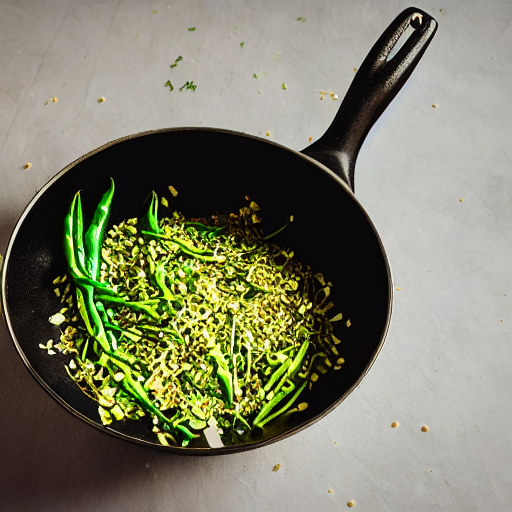


✅ Image generated with Stable Diffusion (GPU-accelerated)!
Prompt used: Professional food photography, close-up, slightly elevated shot: crushed ginger, green chillies, garlic, and coriander seeds actively stir-frying in a hot pan. Warm, diffused kitchen lighting, shallow depth of field, subtle steam, fragrant aroma. Photorealistic, appetizing, high quality.

🔹 STEP 8: Add the crushed ginger, green chillies, garlic, and crushed coriander seeds. Stir fry for about 1 minute until fragrant.

------------------------------------------------------------

🔹 STEP 9: Add the finely chopped onion and sauté until it turns light brown.

------------------------------------------------------------

🔹 STEP 9: Add the finely chopped onion and sauté until it turns light brown.

------------------------------------------------------------

🔹 STEP 10: Now, add the finely chopped coriander leaves, lemon juice, turmeric powder, salt (to taste for the filling), red chilli powder, and garam masala. Stir f

100%|██████████| 30/30 [00:13<00:00,  2.16it/s]




   ✅ Image generated successfully!



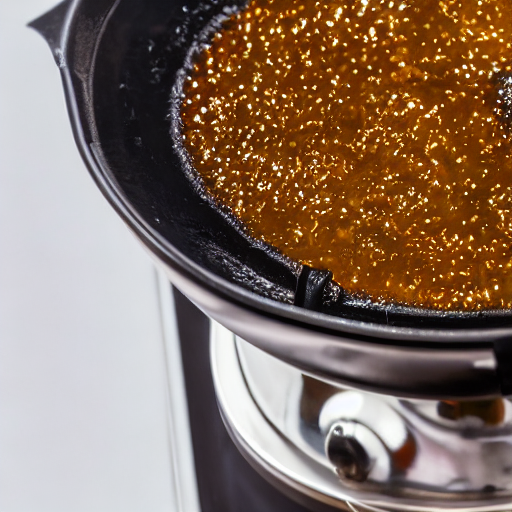


✅ Image generated with Stable Diffusion (GPU-accelerated)!
Prompt used: Professional eye-level close-up of clear cooking oil gently heating in a deep kadai on a stove, soft warm backlighting highlighting the oil's surface, shallow depth of field, clean kitchen background, photorealistic, appetizing, high quality food photography.

🔹 STEP 20: Heat oil for deep frying in a deep pan or kadai over low to medium heat. The oil should be hot enough but not smoking.

------------------------------------------------------------

🔹 STEP 21: Carefully place the prepared samosas into the hot oil. Do not overcrowd the pan; fry in batches.

------------------------------------------------------------

🔹 STEP 21: Carefully place the prepared samosas into the hot oil. Do not overcrowd the pan; fry in batches.

------------------------------------------------------------

🔹 STEP 22: Deep fry the samosas on low to medium heat, turning occasionally, until they turn light golden brown and are crispy. Fry

100%|██████████| 30/30 [00:13<00:00,  2.15it/s]




   ✅ Image generated successfully!



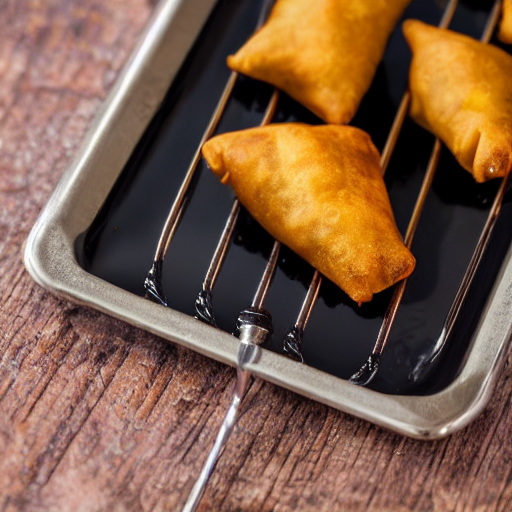


✅ Image generated with Stable Diffusion (GPU-accelerated)!
Prompt used: Professional food photography of golden crispy samosas being carefully lifted from bubbling hot oil with tongs, steam rising, placed onto a wire rack to drain. Warm kitchen lighting, soft focus background, close-up shot, highly detailed, appetizing, photorealistic.

🔹 STEP 23: Once light brown and crispy, remove the samosas from the oil and drain them on a wire rack or kitchen paper to remove excess oil.

------------------------------------------------------------

🔹 STEP 24: Repeat with the remaining dough and filling until all samosas are made and fried.

------------------------------------------------------------

🔹 STEP 24: Repeat with the remaining dough and filling until all samosas are made and fried.

------------------------------------------------------------

💡 COOKING TIPS:
*   **Don't Overfill:** Overfilling can make the samosas difficult to seal and prone to bursting during frying.
*   **Serving Su

In [6]:
def run_recipe_assistant():
    """Main interactive recipe assistant with step-by-step navigation"""
    
    # Step 1: Collect user preferences
    print("=" * 60)
    user_prefs.collect_preferences()
    print("=" * 60)
    
    # Step 2: Get recipe recommendations
    print("\n🔍 Finding perfect recipes for you...\n")
    recommendations = recommender.recommend_recipes(user_prefs)
    print(recommendations)
    print("\n" + "=" * 60)
    
    # Step 3: Let user choose a recipe
    recipe_choice = input("\n📝 Which recipe would you like to cook? (Enter the recipe name): ").strip()
    
    # Step 4: Get detailed instructions
    print(f"\n📖 Getting detailed recipe for: {recipe_choice}...\n")
    detailed_recipe = recommender.get_detailed_recipe(recipe_choice, user_prefs)
    
    # Parse the recipe into structured format
    parsed_recipe = recommender.parse_recipe_steps(detailed_recipe)
    
    # Show ingredients first
    print("\n" + "=" * 60)
    print("📋 INGREDIENTS:")
    print("=" * 60)
    if parsed_recipe['ingredients']:
        print(parsed_recipe['ingredients'])
    else:
        # Fallback: show first part of recipe
        lines = detailed_recipe.split('\n')
        for line in lines[:15]:
            if line.strip():
                print(line)
    
    print("\n" + "=" * 60)
    input("\n⏸️  Press Enter to start cooking instructions...")
    
    # Step 5: Show steps ONE AT A TIME
    steps = parsed_recipe['steps'] if parsed_recipe['steps'] else []
    
    if not steps:
        # Fallback if parsing failed
        print("\n📖 COOKING INSTRUCTIONS:")
        print(detailed_recipe)
    else:
        print("\n" + "=" * 60)
        print("👨‍🍳 COOKING INSTRUCTIONS")
        print("=" * 60)
        print("Type 'next' to see the next step")
        if IMAGE_GENERATION_ENABLED:
            print("Type 'image' to generate a REAL AI image (GPU-accelerated, ~15 seconds)")
        else:
            print("Type 'image' to see a text description of the step")
        print("Type 'skip' to skip to ingredient alternatives")
        print("=" * 60)
        
        for i, step in enumerate(steps):
            while True:
                print(f"\n🔹 {step}")
                print("\n" + "-" * 60)
                
                user_input = input(f"\n👉 [{i+1}/{len(steps)}] Enter command (next/image/skip): ").strip().lower()
                
                if user_input == 'image':
                    if IMAGE_GENERATION_ENABLED:
                        print("\n🎨 Generating REAL image with your RTX 3050 GPU...")
                        print("   This will take about 10-30 seconds...\n")
                        result = recommender.generate_step_image(recipe_choice, step)
                        if isinstance(result, str) and not result.startswith("✅"):
                            # Fallback text description
                            print(f"\n📸 Visual Guide:\n{result}")
                        else:
                            print(f"\n{result}")
                    else:
                        print("\n📝 Generating text description for this step...")
                        image_desc = recommender.generate_step_image_description(recipe_choice, step)
                        print(f"\n📸 Visual Guide:\n{image_desc}")
                        print("\n💡 Note: This is a text description.")
                        print("   To enable REAL GPU images:")
                        print("   1. Run Image_gen.ipynb cells 1-3 to install PyTorch with CUDA")
                        print("   2. Restart this notebook kernel")
                        print("   3. Re-run from Step 2b onwards")
                    
                elif user_input == 'next':
                    break
                    
                elif user_input == 'skip':
                    print("\n⏭️  Skipping to ingredient alternatives...")
                    break
                    
                else:
                    print("❌ Invalid command. Please type 'next', 'image', or 'skip'")
            
            if user_input == 'skip':
                break
        
        # Show tips at the end
        if parsed_recipe['tips']:
            print("\n" + "=" * 60)
            print("💡 COOKING TIPS:")
            print("=" * 60)
            print(parsed_recipe['tips'])
    
    print("\n" + "=" * 60)
    
    # Step 6: Ask about missing ingredients
    missing = input("\n❓ Are you missing any ingredients? (separate with commas, or press Enter to skip): ").strip()
    
    if missing:
        missing_ingredients = [m.strip() for m in missing.split(",") if m.strip()]
        for ingredient in missing_ingredients:
            print(f"\n🔄 Finding alternatives for: {ingredient}...\n")
            alternatives = recommender.get_ingredient_alternatives(ingredient, recipe_choice)
            print(alternatives)
            print("\n" + "-" * 60)
    
    print("\n✨ Happy Cooking! Enjoy your meal! 🍽️")
    print("=" * 60)

# Run the assistant
run_recipe_assistant()

---

## 🎯 MVP Complete with RAG!

### What this MVP does:
1. ✅ Loads recipe PDFs and creates embeddings (RAG knowledge base)
2. ✅ Searches recipe PDFs first, falls back to Gemini AI if not found
3. ✅ Collects user preferences (region, taste, time, allergies, dislikes, ingredients)
4. ✅ Uses LangChain + Gemini AI + RAG to recommend 3 personalized recipes
5. ✅ Provides detailed step-by-step cooking instructions
6. ✅ **Shows ONE step at a time** - user must type "next" to proceed
7. ✅ **Generates image descriptions** for any step when user types "image"
8. ✅ Suggests ingredient alternatives for missing items
9. ✅ Adapts to different cuisines and dietary restrictions

### RAG Implementation:
- **With PDFs**: System searches recipe books first → Uses AI to enhance/format → Best of both worlds!
- **Without PDFs**: System uses only Gemini AI knowledge → Still works great!
- Place your recipe PDF files in the `Pdfs` folder before running

### Interactive Commands:
- **`next`** - Move to the next cooking step
- **`image`** - Generate an AI image of the current step (if enabled) or visual description
- **`skip`** - Skip ahead to ingredient alternatives section

### How to use:
1. **Add Recipe PDFs** (optional but recommended):
   - Create a `Pdfs` folder in the same directory as this notebook
   - Add your recipe book PDFs (any cookbook, recipe collection, etc.)
   - The system will automatically load and index them

2. **Set up API Keys**:
   - **Required**: Google Gemini API key (for recipes & text)
   - **Optional**: Hugging Face token (for REAL image generation)

3. **Enable Image Generation with Google Imagen** (Optional):
   - Get your Google Cloud Project ID from console.cloud.google.com
   - Add `GOOGLE_PROJECT_ID` to your `.env` file
   - Run `gcloud auth application-default login` to authenticate
   - Run Step 2b to enable real image generation with Imagen!
   - See GOOGLE_IMAGEN_SETUP.md for detailed instructions

4. **Run the notebook**:
   - Run Cell 1: Install libraries
   - Run Cell 2: Setup models and API
   - Run Cell 2b: (Optional) Enable image generation
   - Run Cell 3: Load PDFs and create embeddings (RAG)
   - Run Cell 4: Define user preferences class
   - Run Cell 5: Create recipe recommender with RAG
   - Run Cell 6: Start the interactive assistant!

5. **Follow the prompts**:
   - Answer preference questions
   - Get 3 personalized recipe recommendations (from PDFs + AI)
   - Choose a recipe and get step-by-step instructions
   - Type "next", "image", or "skip" at each step
   - If image generation is enabled, you'll see REAL AI-generated images!

### Example Flow:
```
1. System loads recipe PDFs → Creates embeddings
2. Answer preference questions (cuisine, taste, time, etc.)
3. System searches PDFs for matching recipes
4. Get 3 recipe recommendations (RAG-enhanced)
5. Choose a recipe
6. System retrieves detailed recipe from PDFs (if available)
7. See ingredients list → Press Enter
8. See Step 1 → type "image" to visualize OR "next" to continue
9. See Step 2 → type "next"
10. Continue until complete
11. Get ingredient alternatives if needed
```

### Architecture:
```
User Input → RAG Search (PDFs) → Retrieve Context → LLM Enhancement → Output
                ↓ (if not found)
           Gemini AI Fallback → Generate Recipe → Output
```

### Next Steps (Future Enhancements):
- ✅ **DONE**: Real AI image generation with Google Imagen!
- Save user preferences and favorite recipes
- Add nutritional information
- Create a web interface with Streamlit
- Add voice guidance
- Support for multiple recipe book sources
- Voice-guided cooking instructions